In [1]:
import pandas as pd
import numpy as np
import random

import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from xgboost import XGBRegressor
import xgboost as xgb

# # 1) Detección de tipos
# sample   = pd.read_csv('../data/ventas_featurev3.csv', nrows=1000)
# float64_cols = sample.select_dtypes(include='float64').columns.tolist()
# obj_cols     = sample.select_dtypes(include='object').columns.tolist()

# # 2) Mapear float64→float32 y object→category
# dtype_map = {c: 'float32' for c in float64_cols}
# dtype_map.update({c: 'category' for c in obj_cols})

# # 3) Leer con dtype_map
# df = pd.read_csv('../data/ventas_featurev3.csv', dtype=dtype_map)

# # 4) (Opcional) si de verdad quieres float16:
# for c in float64_cols:
#     df[c] = df[c].astype(np.float16)

# print(df.info(memory_usage='deep'))

# Cargar el dataset
df = pd.read_csv('../data/ventas_featurev4.csv', sep=',')

c:\Users\leona\anaconda3\envs\gpu_boost\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Convertir todas las columnas float64 a float16 en sell_in_featured1
float64_cols = df.select_dtypes(include=['float64']).columns
df[float64_cols] = df[float64_cols].astype('float16')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16763760 entries, 0 to 16763759
Data columns (total 97 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   periodo                    object 
 1   customer_id                int64  
 2   product_id                 int64  
 3   plan_precios_cuidados      float16
 4   tn                         float16
 5   cust_request_qty           float16
 6   cust_request_tn            float16
 7   cat1                       object 
 8   cat2                       object 
 9   cat3                       object 
 10  brand                      object 
 11  sku_size                   int64  
 12  descripcion                object 
 13  productos_estrella         int64  
 14  mes                        int64  
 15  catastrofe                 int64  
 16  cliente_estrella           int64  
 17  prod_cust                  object 
 18  tn_lag_1                   float16
 19  tn_lag_2                   float16
 20  

In [3]:
SEED = 26461180
random.seed(SEED)
np.random.seed(SEED)

# Convertir 'periodo' de fecha a entero tipo YYYYMM
df["periodo"] = pd.to_datetime(df["periodo"])
df["periodo"] = df["periodo"].dt.strftime("%Y%m").astype(int)


In [4]:
df.head()

c:\Users\leona\anaconda3\envs\gpu_boost\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\leona\anaconda3\envs\gpu_boost\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,periodo,customer_id,product_id,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,cat1,cat2,cat3,...,delta_tn_lag_33,delta_tn_lag_34,delta_tn_lag_35,ipc,var_mensual,var_anual,promedio_mens_dolar_venta,temp_media,temp_max_media,temp_min_media
0,201701,10001,20001,0.0,99.437500,11.0,99.437500,HC,ROPA LAVADO,Liquido,...,NaN,NaN,NaN,101.5625,1.589844,24.796875,15.90625,25.65625,30.40625,20.90625
1,201701,10002,20001,0.0,35.718750,17.0,38.687500,HC,ROPA LAVADO,Liquido,...,NaN,NaN,NaN,101.5625,1.589844,24.796875,15.90625,25.65625,30.40625,20.90625
2,201701,10003,20001,0.0,143.500000,17.0,143.500000,HC,ROPA LAVADO,Liquido,...,NaN,NaN,NaN,101.5625,1.589844,24.796875,15.90625,25.65625,30.40625,20.90625
3,201701,10004,20001,0.0,184.750000,9.0,184.750000,HC,ROPA LAVADO,Liquido,...,NaN,NaN,NaN,101.5625,1.589844,24.796875,15.90625,25.65625,30.40625,20.90625
4,201701,10005,20001,0.0,19.078125,23.0,19.078125,HC,ROPA LAVADO,Liquido,...,NaN,NaN,NaN,101.5625,1.589844,24.796875,15.90625,25.65625,30.40625,20.90625


In [5]:
# 1. Crear dataset de entrenamiento
df_train = df.copy()
df_train2 = df.copy()

In [6]:
df_train.head()

c:\Users\leona\anaconda3\envs\gpu_boost\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\leona\anaconda3\envs\gpu_boost\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,periodo,customer_id,product_id,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,cat1,cat2,cat3,...,delta_tn_lag_33,delta_tn_lag_34,delta_tn_lag_35,ipc,var_mensual,var_anual,promedio_mens_dolar_venta,temp_media,temp_max_media,temp_min_media
0,201701,10001,20001,0.0,99.437500,11.0,99.437500,HC,ROPA LAVADO,Liquido,...,NaN,NaN,NaN,101.5625,1.589844,24.796875,15.90625,25.65625,30.40625,20.90625
1,201701,10002,20001,0.0,35.718750,17.0,38.687500,HC,ROPA LAVADO,Liquido,...,NaN,NaN,NaN,101.5625,1.589844,24.796875,15.90625,25.65625,30.40625,20.90625
2,201701,10003,20001,0.0,143.500000,17.0,143.500000,HC,ROPA LAVADO,Liquido,...,NaN,NaN,NaN,101.5625,1.589844,24.796875,15.90625,25.65625,30.40625,20.90625
3,201701,10004,20001,0.0,184.750000,9.0,184.750000,HC,ROPA LAVADO,Liquido,...,NaN,NaN,NaN,101.5625,1.589844,24.796875,15.90625,25.65625,30.40625,20.90625
4,201701,10005,20001,0.0,19.078125,23.0,19.078125,HC,ROPA LAVADO,Liquido,...,NaN,NaN,NaN,101.5625,1.589844,24.796875,15.90625,25.65625,30.40625,20.90625


In [7]:
df["periodo"] = df["periodo"].astype(int)

In [8]:
# Convierte todas las columnas object a category
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')


In [9]:

# 2. Generar dataset de predicción para 202002
# Tomamos los registros de 201912 como base y simulamos las features
df_201912 = df[df["periodo"] == 201912].copy()
df_pred = df_201912.copy()
df_pred["periodo"] = 202002  # Simulamos el período futuro

In [10]:
df_pred.head()

c:\Users\leona\anaconda3\envs\gpu_boost\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\leona\anaconda3\envs\gpu_boost\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,periodo,customer_id,product_id,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,cat1,cat2,cat3,...,delta_tn_lag_33,delta_tn_lag_34,delta_tn_lag_35,ipc,var_mensual,var_anual,promedio_mens_dolar_venta,temp_media,temp_max_media,temp_min_media
20895,202002,10001,20001,0.0,180.250000,18.0,214.750000,HC,ROPA LAVADO,Liquido,...,180.250000,180.250000,180.250000,283.5,3.740234,53.84375,59.875,24.0,29.5,18.0
20896,202002,10002,20001,0.0,113.312500,20.0,115.312500,HC,ROPA LAVADO,Liquido,...,113.312500,113.312500,113.312500,283.5,3.740234,53.84375,59.875,24.0,29.5,18.0
20897,202002,10003,20001,0.0,102.250000,9.0,114.000000,HC,ROPA LAVADO,Liquido,...,102.125000,102.250000,102.250000,283.5,3.740234,53.84375,59.875,24.0,29.5,18.0
20898,202002,10004,20001,0.0,34.656250,8.0,34.656250,HC,ROPA LAVADO,Liquido,...,34.656250,34.531250,34.656250,283.5,3.740234,53.84375,59.875,24.0,29.5,18.0
20899,202002,10005,20001,0.0,19.609375,25.0,19.609375,HC,ROPA LAVADO,Liquido,...,19.609375,19.609375,19.484375,283.5,3.740234,53.84375,59.875,24.0,29.5,18.0


In [11]:
cat_cols = ["cat1", "cat2", "cat3", "brand","prod_cust", "descripcion"]
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16763760 entries, 0 to 16763759
Data columns (total 97 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   periodo                    int64   
 1   customer_id                int64   
 2   product_id                 int64   
 3   plan_precios_cuidados      float16 
 4   tn                         float16 
 5   cust_request_qty           float16 
 6   cust_request_tn            float16 
 7   cat1                       category
 8   cat2                       category
 9   cat3                       category
 10  brand                      category
 11  sku_size                   int64   
 12  descripcion                category
 13  productos_estrella         int64   
 14  mes                        int64   
 15  catastrofe                 int64   
 16  cliente_estrella           int64   
 17  prod_cust                  category
 18  tn_lag_1                   float16 
 19  tn_lag_2           

In [13]:
from sklearn.model_selection import train_test_split

dfx_train = df_train2.drop(columns=["tn"], errors="ignore") #, "periodo", "descripcion", "prod_cust"
dfy_train = df_train["tn"]

X_train, X_val, y_train, y_val = train_test_split(dfx_train, dfy_train, test_size=0.2, random_state=SEED)

In [14]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor

# # Subsample del dataset para que no explote (¡no uses los 16M en GridSearch!)
# X_sample = X_train.sample(n=100_000, random_state=SEED)
# y_sample = y_train.loc[X_sample.index]

# param_grid = {
#     "max_depth": [4, 6, 8],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "n_estimators": [50, 100, 200],
#     "subsample": [0.5, 0.8, 1.0],
#     "colsample_bytree": [0.5, 0.8, 1.0],
#     "gamma": [0, 0.1, 0.2],
#     "reg_alpha": [0, 0.1, 0.5],
# }

# model = XGBRegressor(enable_categorical=True, n_jobs=-1)

# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring="neg_root_mean_squared_error",
#     cv=3,
#     verbose=1
# )

# grid_search.fit(X_sample, y_sample)

# print("✅ Mejor combinación:", grid_search.best_params_)
# print("📉 Mejor score (RMSE negativo):", grid_search.best_score_)


In [15]:
# from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
# from xgboost import XGBRegressor

# categorical_cols = ['cat1','cat2','cat3','brand']

# X_sample = X_train.sample(n=500_000, random_state=SEED)
# for c in categorical_cols:
#     X_sample[c] = X_sample[c].astype('category').cat.codes
    
# y_sample = y_train.loc[X_sample.index]

# tscv = TimeSeriesSplit(n_splits=10)

# xgb_model = XGBRegressor(
#     tree_method='gpu_hist',  # Usar GPU si está disponible
#     predictor='gpu_predictor',
#     objective='reg:squarederror',
#     random_state=SEED,
#     n_jobs=-1,  # Usar todos los núcleos disponibles
#     enable_categorical=True
# )


# param_dist = {
#     'max_depth': [3, 4, 6, 8],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [50, 100, 200, 300],
#     'subsample': [0.5, 0.7, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.2, 0.5],
#     'reg_alpha': [0, 0.1, 0.5, 1.0],
#     'min_child_weight': [1, 3, 5, 8]
# }

# rs = RandomizedSearchCV(
#     estimator=xgb_model,
#     param_distributions=param_dist,
#     n_iter=100,
#     scoring='neg_root_mean_squared_error',
#     cv=tscv,
#     random_state=SEED,
#     verbose=2,
#     n_jobs=-1
# )


In [16]:
# # Ejecutar búsqueda
# rs.fit(X_sample, y_sample)

# # Resultados
# top_params = rs.best_params_
# best_rmse = rs.best_score_
# print("✅ Mejores hiperparámetros:", top_params)
# print(f"📉 Mejor RMSE: {best_rmse:.4f}")

In [16]:
categorical_cols = ['cat1','cat2','cat3','brand','prod_cust', 'descripcion']
X_sample = X_train.sample(n=1000_000, random_state=SEED).copy()
for c in categorical_cols:
    X_sample[c] = X_sample[c].astype('category').cat.codes
y_sample = y_train.loc[X_sample.index]

# 2) Definir el splitter
tscv = TimeSeriesSplit(n_splits=10)

# 3) Definir la función objetivo de Optuna
def objective(trial):
    params = {
        'tree_method':        'gpu_hist',
        'predictor':          'gpu_predictor',
        'objective':          'reg:squarederror',
        'random_state':       SEED,
        'enable_categorical': True,

        # hiperparámetros a optimizar
        'max_depth':          trial.suggest_int   ('max_depth',         3,   8),
        'learning_rate':      trial.suggest_loguniform('learning_rate',  1e-2, 2e-1),
        'n_estimators':       trial.suggest_int   ('n_estimators',      50, 300),
        'subsample':          trial.suggest_uniform('subsample',       0.5, 1.0),
        'colsample_bytree':   trial.suggest_uniform('colsample_bytree',0.6, 1.0),
        'gamma':              trial.suggest_uniform('gamma',           0.0, 0.5),
        'reg_alpha':          trial.suggest_loguniform('reg_alpha',     1e-3, 1.0),
        'min_child_weight':   trial.suggest_int   ('min_child_weight', 1,   8),
    }
    model = XGBRegressor(**params)
    # cross-val con scoring = neg_root_mean_squared_error
    scores = cross_val_score(
        model, X_sample, y_sample,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
    )
    # Optuna maximiza lo que devuelve objective, así que devolvemos la media
    return scores.mean()

# 4) Crear y lanzar el estudio
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 5) Extraer y presentar resultados al estilo que tenías
top_params = study.best_params
best_rmse  = -study.best_value  # negativo porque usamos neg_root_mean_squared_error

print("✅ Mejores hiperparámetros:", top_params)
print(f"📉 Mejor RMSE: {best_rmse:.4f}")

[I 2025-06-27 22:23:39,268] A new study created in memory with name: no-name-3166fbac-f20f-4bfd-af22-670750372ac2
C:\Users\leona\AppData\Local\Temp\ipykernel_15236\3020208300.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':      trial.suggest_loguniform('learning_rate',  1e-2, 2e-1),
C:\Users\leona\AppData\Local\Temp\ipykernel_15236\3020208300.py:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':          trial.suggest_uniform('subsample',       0.5, 1.0),
C:\Users\leona\AppData\Local\Temp\ipykernel_15236\3020208300.py:24: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/op

✅ Mejores hiperparámetros: {'max_depth': 5, 'learning_rate': 0.10382535121323716, 'n_estimators': 269, 'subsample': 0.5483708087272724, 'colsample_bytree': 0.9491900989174965, 'gamma': 0.38347843529776526, 'reg_alpha': 0.34700076475712205, 'min_child_weight': 1}
📉 Mejor RMSE: 0.5747


In [17]:
# Eliminar la columna de respuesta original (tn)
df_pred = df_pred.drop(columns=["tn"], errors="ignore")

# 3. Crear X_pred antes de convertir tipos
X_pred = df_pred.drop(columns=["descripcion", "prod_cust"], errors="ignore")

# 4. Convertir columnas categóricas a dtype 'category'
cat_cols = ["cat1", "cat2", "cat3", "brand"]
for col in cat_cols:
    if col in X_pred.columns:
        X_pred[col] = X_pred[col].astype("category")
        
# Columnas categóricas que vas a usar
categorical_cols = ["cat1", "cat2", "cat3", "brand"]

# 1) Quitar columnas irrelevantes de entrenamiento y validación
X_train = X_train.drop(columns=["descripcion", "prod_cust"], errors="ignore")
X_val   = X_val.drop(columns=["descripcion", "prod_cust"], errors="ignore")

# 2) Convertir a 'category' en ambos conjuntos
for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_val[col]   = X_val[col].astype("category")        
        
# 3. Entrenar el modelo
# ✅ Mejores hiperparámetros: {'max_depth': 5, 'learning_rate': 0.10382535121323716, 'n_estimators': 269, 
# 'subsample': 0.5483708087272724, 'colsample_bytree': 0.9491900989174965, 'gamma': 0.38347843529776526, 
# 'reg_alpha': 0.34700076475712205, 'min_child_weight': 1}
# 📉 Mejor RMSE: 0.5747

# 3) Early stopping como callback:

model = XGBRegressor(objective='reg:squarederror',
                    n_estimators=269, 
                    learning_rate=0.103825, 
                    max_depth=5, 
                    subsample=0.548370,
                    colsample_bytree=0.949190,
                    gamma=0.383478,
                    reg_alpha=0.347000,
                    min_child_weight=1,
                    tree_method='hist',      # ahora el método de árbol “hist”
                    device='cuda:0',           # en lugar de gpu_hist
                    single_precision_histogram=True,  # mejora uso memoria (opcional)
                    n_jobs=-1,
                    random_state=SEED,
                    enable_categorical=True,
                    alpha=1,
                    early_stopping_rounds=10)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

c:\Users\leona\anaconda3\envs\gpu_boost\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:05:47] WARNING: D:\bld\xgboost-split_1748292846627\work\src\learner.cc:738: 
Parameters: { "single_precision_histogram" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:1.17344
[1]	validation_0-rmse:1.08990
[2]	validation_0-rmse:1.01562
[3]	validation_0-rmse:0.95184
[4]	validation_0-rmse:0.89611
[5]	validation_0-rmse:0.85048
[6]	validation_0-rmse:0.80812
[7]	validation_0-rmse:0.77280
[8]	validation_0-rmse:0.74582
[9]	validation_0-rmse:0.72127
[10]	validation_0-rmse:0.70197
[11]	validation_0-rmse:0.68346
[12]	validation_0-rmse:0.67134
[13]	validation_0-rmse:0.66025
[14]	validation_0-rmse:0.64906
[15]	validation_0-rmse:0.63905
[16]	validation_0-rmse:0.63045
[17]	validation_0-rmse:0.62190
[18]	validation_0-rmse:0.61503
[19]	validation_0-rmse:0.60910
[20]	validation_0-rmse:0.60288
[21]	validation_0-rmse:0.59853
[22]	validation_0-rmse:0.59368
[23]	validation_0-rmse:0.59115
[24]	validation_0-rmse:0.58672
[25]	validation_0-rmse:0.58455
[26]	validation_0-rmse:0.58298
[27]	validation_0-rmse:0.57945
[28]	validation_0-rmse:0.57653
[29]	validation_0-rmse:0.57406
[30]	validation_0-rmse:0.57183
[31]	validation_0-rmse:0.57035
[32]	validation_0-

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.94919
,device,'cuda:0'
,early_stopping_rounds,10
,enable_categorical,True
,eval_metric,None


In [ ]:
# # Eliminar la columna de respuesta original (tn)
# df_pred = df_pred.drop(columns=["tn"], errors="ignore")

# # 3. Crear X_pred antes de convertir tipos
# X_pred = df_pred.drop(columns=["periodo", "descripcion", "prod_cust"], errors="ignore")

# # 4. Convertir columnas categóricas a dtype 'category'
# cat_cols = ["cat1", "cat2", "cat3", "brand"]
# for col in cat_cols:
#     if col in X_train.columns:
#         X_pred[col] = X_pred[col].astype("category")
        
# # 3. Entrenar el modelo
# model = XGBRegressor(n_estimators=100, 
#                     learning_rate=0.1, 
#                     max_depth=4, 
#                     subsample=1.0,
#                     colsample_bytree=0.6,
#                     gamma=0.1,
#                     reg_alpha=1.0,
#                     min_child_weight=3,
#                     n_jobs=-1, 
#                     random_state=SEED, 
#                     enable_categorical=True,
#                     tree_method='gpu_hist',  # Usar GPU si está disponible
#                     predictor='gpu_predictor',)
# model.fit(X_train, y_train)

In [18]:
print("✅ X_train shape:", X_train.shape)
print("✅ X_pred shape:", X_pred.shape)
print("🔍 Columns in X_train:", X_train.columns.tolist())
print("🔍 Columns in X_pred:", X_pred.columns.tolist())
print("🔍 Missing columns in X_pred:", set(X_train.columns) - set(X_pred.columns))

✅ X_train shape: (13411008, 94)
✅ X_pred shape: (465660, 94)
🔍 Columns in X_train: ['periodo', 'customer_id', 'product_id', 'plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'productos_estrella', 'mes', 'catastrofe', 'cliente_estrella', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5', 'tn_lag_6', 'tn_lag_7', 'tn_lag_8', 'tn_lag_9', 'tn_lag_10', 'tn_lag_11', 'tn_lag_12', 'tn_lag_13', 'tn_lag_14', 'tn_lag_15', 'tn_lag_16', 'tn_lag_17', 'tn_lag_18', 'tn_lag_19', 'tn_lag_20', 'tn_lag_21', 'tn_lag_22', 'tn_lag_23', 'tn_lag_24', 'tn_lag_25', 'tn_lag_26', 'tn_lag_27', 'tn_lag_28', 'tn_lag_29', 'tn_lag_30', 'tn_lag_31', 'tn_lag_32', 'tn_lag_33', 'tn_lag_34', 'tn_lag_35', 'tn_lag_36', 'tn_mas_2', 'delta_tn_lag_1', 'delta_tn_lag_2', 'delta_tn_lag_3', 'delta_tn_lag_4', 'delta_tn_lag_5', 'delta_tn_lag_6', 'delta_tn_lag_7', 'delta_tn_lag_8', 'delta_tn_lag_9', 'delta_tn_lag_10', 'delta_tn_lag_11', 'delta_tn_lag_12', 'delta_tn_lag_

In [19]:
# 4. Hacer predicciones sobre 202002

df_pred["tn_pred"] = model.predict(X_pred)

# 5. Agrupar por product_id y exportar resultados
df_result = (
    df_pred.groupby("product_id")["tn_pred"]
    .sum()
    .reset_index()
    .rename(columns={"tn_pred": "tn"})
)

df_result.to_csv("../data/submission_xgboost_202002_v7.csv", index=False)

print("✅ Archivo generado: submission_xgboost_202002_v7.csv")


c:\Users\leona\anaconda3\envs\gpu_boost\Lib\site-packages\xgboost\core.py:705: UserWarning: [20:06:47] WARNING: D:\bld\xgboost-split_1748292846627\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


✅ Archivo generado: submission_xgboost_202002_v7.csv


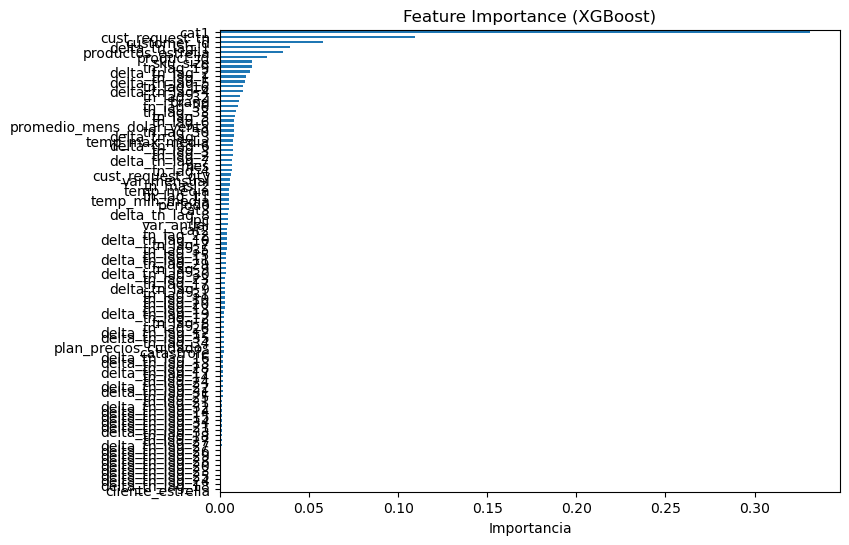

In [20]:
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt

# 2) Extrae importancias
importances = pd.Series(model.feature_importances_, index=X_train.columns)

# 3) Ordena y grafica
importances = importances.sort_values(ascending=True)
plt.figure(figsize=(8,6))
importances.plot(kind='barh')
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importancia')
plt.show()

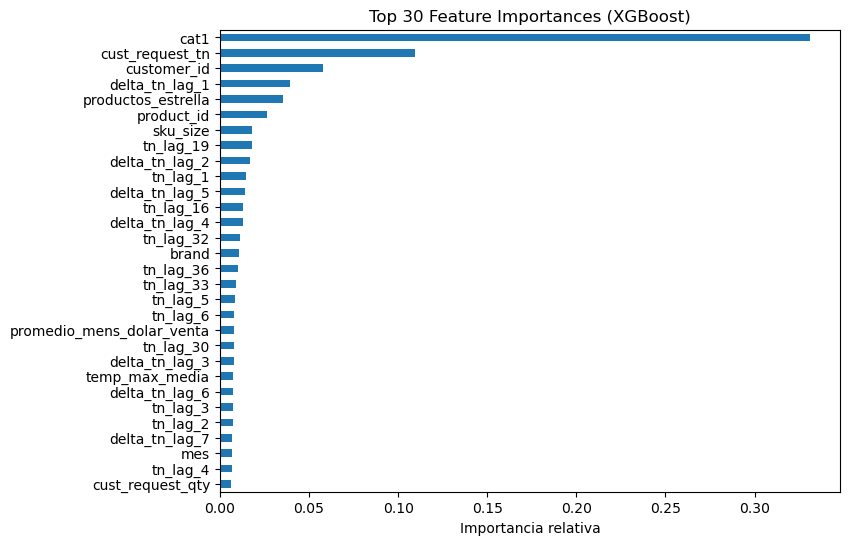

In [23]:
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt

# 2) Extrae importancias
importances = pd.Series(model.feature_importances_, index=X_train.columns)

# 3) Selecciona las top N (por ejemplo 15)
N = 30
topN = importances.nlargest(N).sort_values(ascending=True)

# 4) Grafica solo esas
plt.figure(figsize=(8,6))
topN.plot(kind='barh')
plt.title(f'Top {N} Feature Importances (XGBoost)')
plt.xlabel('Importancia relativa')
plt.show()

In [19]:
# Get feature importances
#feature_importances = model.feature_importances_
importances = pd.Series(model.feature_importances_, index=X_val.columns)
importances = importances.sort_values(ascending=True)

# Display feature importances
for name, importance in enumerate(importances):
    print(f"Feature {name}: {importance}")

Feature 0: 0.0
Feature 1: 0.00012391831842251122
Feature 2: 0.00025519650080241263
Feature 3: 0.0003219210193492472
Feature 4: 0.00039591724635101855
Feature 5: 0.0005125260213389993
Feature 6: 0.0005479412502609193
Feature 7: 0.0005716874729841948
Feature 8: 0.0006441441946662962
Feature 9: 0.0010060907807201147
Feature 10: 0.001020808587782085
Feature 11: 0.0010456567397341132
Feature 12: 0.0010754427639767528
Feature 13: 0.001091902726329863
Feature 14: 0.0011222726898267865
Feature 15: 0.00112682837061584
Feature 16: 0.001198550220578909
Feature 17: 0.0013181138783693314
Feature 18: 0.0013761847512796521
Feature 19: 0.0014283079653978348
Feature 20: 0.0014526472659781575
Feature 21: 0.0015085877384990454
Feature 22: 0.0015785578871145844
Feature 23: 0.0017024044645950198
Feature 24: 0.0017287037335336208
Feature 25: 0.0017476218054071069
Feature 26: 0.0018156460719183087
Feature 27: 0.001966723706573248
Feature 28: 0.002038949867710471
Feature 29: 0.002180793322622776
Feature 30: 0

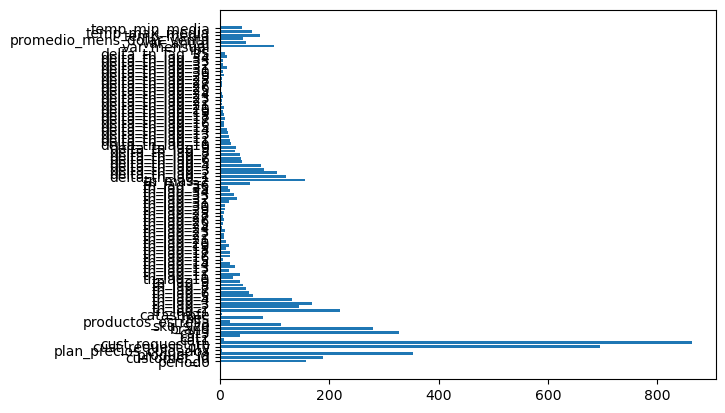

In [20]:
# Assuming that 'model' is a trained XGBoost model
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

plt.barh(keys, values)
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

# Assuming that 'model' is the trained XGBoost model and 'X_val' and 'y_val' are validation datasets
results = permutation_importance(
    model, X_val, y_val,
    scoring='r2',             # usa R² como métrica
    n_repeats=10,
    random_state=SEED
)
importance = results.importances_mean

for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' %(i,v))

In [24]:
import shap

# # Assuming that 'model' is the trained XGBoost model and 'X_train' is the training dataset
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_train)

# shap.summary_plot(shap_values, X_train)

model.set_param({'predictor':'cpu_predictor'})
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

AttributeError: 'XGBRegressor' object has no attribute 'set_param'

In [25]:
from shap.explainers import GPUTree
explainer = GPUTree(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

ValueError: could not convert string to float: 'PC'